# Assignment 2: Keeping Up With Social Information (Optional Extra Credit)
## © Cristian Danescu-Niculescu-Mizil 2018
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday February 21st

This assignment is **individual**.

In this assignment we will doing some advanced analysis on the transcripts from the reality TV show "Keeping Up With The Kardashians" as a supplement to Assignment 2. Here we will be looking at character priming.


**Extra Credit Policy**

The policy for this extra credit is that you should complete as much as you can. This assignment is out of 60 points and is worth 2 extra credit points. 


**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* Character priming
* Conversation analysis 

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented to ensure that your logic is correct.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

You are expected to submit this .ipynb as your submission for Assignment 2. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

In [1]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt
# Imports that might help with various functionality
import functools
import operator

In [2]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

To ensure that you are comfortable moving forward. Make sure that you are familair with the following data structures that were used in Assignment 2:
* deduped_transcripts
* titles
* good_types
* good_speakers
* good_types_reverse_index
* good_pairs_reverse_index

In [3]:
## We are loading: deduped transcripts from Assignment 2
with open('deduped_transcripts.pickle','rb') as f:
    deduped_transcripts = pickle.load(f)
## We are loading: the titles from Assignment 2
with open('titles.pickle','rb') as f:
    titles = pickle.load(f)
## We are loading: the good_types from Assignment 2
with open('good_types.pickle','rb') as f:
    good_types = pickle.load(f) 
## We are loading: the reply_matrix from Assignment 2
with open('reply_matrix.pickle','rb') as f:
    reply_matrix = pickle.load(f) 
n_good_types = len(good_types)
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']
good_types_reverse_index = {t: i for i, t in enumerate(good_types)}
good_pairs_reverse_index = {(0, 2): 0,
 (0, 5): 1,
 (2, 3): 2,
 (2, 4): 3,
 (2, 5): 4,
 (3, 4): 5,
 (3, 5): 6,
 (4, 5): 7,
 (4, 7): 8}
n_good_speakers = len(good_speakers)
def tokenize(text):
    """Returns a list of words that make up the text.    
    Params: {text: String}
    Returns: Array
    """
    return [x for x in re.findall(r"[a-z]*", text.lower()) if x != ""]

In [4]:
# Ensure that the pickled data stuctures are correct
assert type(deduped_transcripts[0]) == tuple
assert type(titles) == dict
assert n_good_types == 4517
assert n_good_speakers == 8

## Priming. How much is a character's word choice influenced by the person they are speaking to?

[Priming](https://en.wikipedia.org/wiki/Priming_(psychology) is the phenomenon where a speaker tends to repeat certain words or language characteristics of the person they are replying to. It turns out that priming can often be observed in conversation. If A is talking to B, B will sometimes tend to use mirror A's language. We define a simple approximation of this, probabilistically, as follows:

## Question 1 (Code Completion): Character Priming

In this analysis we will be looking at priming: i.e. when speaker A replies to speaker B, what is the probability that a word said by B will be repeated by A? 

That is, how many of the words in A's reply were also said by B (normalized by the number of words A said in total)?
Specifically, consider the following example:

```
Cristian: Hi Ilan, it is a really nice day today. Yes, it is.
Ilan: It is a really really nice day today! Yes.
```

We should take the set of all words said by Cristian here (hi, ilan, it, is, a, really, nice, day, today, yes) $W_c$ and the set of all words said by Ilan here (it is a really nice day today yes) $W_i$, and compute $\frac{|W_c \cap W_i|}{|W_i|}$.

For a specific *ordered* pair of speakers A and B, we then calculate the *arithmetic mean* among all pairs of adjacent utterences by them to get a single number between 0 and 1 as the answer to this question.

The next couple methods will walk you through necessary pre-computations to get this priming matrix.
Do read through these functions carefully as you will be using their results.

In [5]:
def merge_deduped(stuff):
    """Merge adjacent comments"""
    result = [] 
    for t_id, tscript in stuff:
        prev_speaker = tscript[0]['speaker']
        prev_line = tscript[0]['text']
        tscript_result = [] 
        for i in range(1, len(tscript)): 
            curr_speaker = tscript[i]['speaker']
            curr_line = tscript[i]['text']
            if curr_speaker == prev_speaker: 
                prev_line = prev_line + " " + curr_line 
            else: 
                tscript_result.append({'speaker': prev_speaker, 
                                       'text': prev_line})
                prev_speaker = curr_speaker 
                prev_line    = curr_line 
            if i == len(tscript)-1: 
                tscript_result.append({'speaker': prev_speaker, 
                                        'text': prev_line})
        result.append((t_id, tscript_result))
    return result 

merged_deduped_transcripts = merge_deduped(deduped_transcripts) 

def prev_lines_and_replies(A, B, tscript): 
    """Creates an array of all the transcript lines 
    involving supposed correspondence between A 
    (first speaker) and B (second speaker) (both
    previous message and current message)"""
    
    # Prepare results for B responses to A, 
    # previous speak 
    result = []
    prev_speaker = None 
    prev_line = None
    
    # Go through every line of the transcript 
    for line in tscript:
        curr_speaker = line['speaker']
        
        # If dialogue has happened 
        if ((curr_speaker == B and prev_speaker == A)): 
            # Add the previous line and the current line 
            result.append([prev_line, line])
        
        # Update the speaker + line 
        prev_speaker = curr_speaker 
        prev_line = line 
            
    return result


def ordered_lines_for_pair(A, B):
    """Gathers all lines in all transcripts for an
    ORDERED pair of characters"""
    
    result = [] 

    for _, tscript in merged_deduped_transcripts:
        result = result + prev_lines_and_replies(A, B, tscript)
    return result 

def ordered_pairs_all_lines():
    """Gathers all lines in all transcripts for all ORDERED pairs 
    of good characters"""
    
    result = dict()  
    
    # Setup pairings (tuples)
    for i in range(0, n_good_speakers):
        for j in range(0, n_good_speakers): 
            if i != j: 
                tup = [i, j]
                tup = tuple(tup)
                result[tup] = [] 
    
    # Gather lines per pair 
    for tup in result.keys():
        A = good_speakers[tup[0]]
        B = good_speakers[tup[1]]
        result[tup] = ordered_lines_for_pair(A, B)
    
    return result 

# Groupings per pair 
ordered_pairs_lines = ordered_pairs_all_lines()

In the cell below, fulfill the specification to return a priming matrix:

*Note: Ensure that they are only good_types*

In [73]:
def create_pair_priming_mat(tokenize_method,
                             input_ordered_pair_lines,
                             input_n_speakers):
    """Returns a numpy array of size `n_speakers` by `n_speakers`
    where entry (ij) is how many of the words in i's reply were also 
    said by j (normalized by the number of words i said in total).
    
    Hint: Use numpy primitives to make this function optimal.
          You should use the good_types_reverse_index global variable. 
    
    Steps: 
        1. For each tup (for each pair i,j)
        2. Grab set of words (only good types)
        3. Do necessary priming calculations 
        
    Note: Don't forget to add 1 to the sum of each column 
    to handle divide by 0 issues!
    
    Params: {tokenize_method: Function a -> b,
             input_ordered_pairs: Dict,
             input_n_speakers: Integer}
    Returns: Numpy array
    """
    # YOUR CODE HERE
    pair_priming_mat = np.zeros((input_n_speakers, input_n_speakers))
    for i in range(input_n_speakers):
        for j in range(input_n_speakers):
            if i != j:
                pair_lines = input_ordered_pair_lines[(i,j,)]
                score  = 0.
                if len(pair_lines) != 0:
                    for lines_and_replies in pair_lines:
                        line = set(tokenize_method(lines_and_replies[0]['text']))
                        reply = set(tokenize_method(lines_and_replies[1]['text']))
                        good_type_intersection = 0.
                        for word in line.intersection(reply):
                            if word in good_types_reverse_index.keys():
                                good_type_intersection += 1.
                        score += good_type_intersection/len(reply)
                    score = score/len(pair_lines)
                pair_priming_mat[i][j] = score
    return pair_priming_mat
                
    raise NotImplementedError()

In [74]:
pair_priming_mat = create_pair_priming_mat(tokenize,ordered_pairs_lines,n_good_speakers)

In [75]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that pair_priming_mat returns the correct output"""
assert type(pair_priming_mat) == np.ndarray
assert pair_priming_mat.shape == (8,8)
assert pair_priming_mat[0][0] == 0.0
assert sum(pair_priming_mat[0]) > 0.8
assert sum(pair_priming_mat[5]) > 0.7 and sum(pair_priming_mat[5]) < 0.9

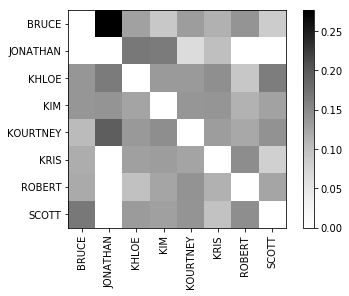

In [76]:
plt.imshow(pair_priming_mat, interpolation='none', cmap=plt.cm.Greys)
plt.colorbar()
plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show() 

It is also interesting to note: which are the top 3 pairs where a character is most likely to systematically repeat words that another uses? and what are the 3 pairs least likely to repeat words? 

In this case, these would be *ordered* pairs, since, for example, Kim might tend to mimic Kourtney more than the other way around.

In the code we provided below we have ignored *ordered* pairs that have fewer than 100 words. Analyze the code and results provided:

In [44]:
mat_items = []
for i in range(n_good_speakers):
    for j in range(n_good_speakers):
        if i != j and reply_matrix[i, j] >= 100:
            mat_items.append((pair_priming_mat[i, j], (i, j)))
mat_items.sort() 

print("Top 3 pairs:")
top_3_priming_pairs = []
for score, (i, j) in reversed(mat_items[-3:]):
    top_3_priming_pairs.append((i, j))
    print(" -", good_speakers[i], "repeats", good_speakers[j], "( score:", round(score, 5), ")")
print("Bottom 3 pairs:")
for score, (i, j) in reversed(mat_items[:3]):
    print(" -", good_speakers[i], "repeats", good_speakers[j], "( score:", round(score, 5), ")")

Top 3 pairs:
 - SCOTT repeats BRUCE ( score: 0.16662 )
 - KRIS repeats ROBERT ( score: 0.14662 )
 - KOURTNEY repeats KIM ( score: 0.14523 )
Bottom 3 pairs:
 - KHLOE repeats ROBERT ( score: 0.0916 )
 - BRUCE repeats KIM ( score: 0.08962 )
 - BRUCE repeats SCOTT ( score: 0.08537 )


## Question 1b (Free Response): Character Priming

In the cell below, please use Markdown to describe anything that you notice about the heatmap generated from the priming matrix as well as the results above, in regards to the top/bottom 3 priming pairs. Were you expecting these results or are were you surprised?  

The most obvious result from the heatmap is that the score between the pair Bruce and Jonathan is the highest and much higher than other pairs. Another interesting thing about Jonathan is that he only interact with four characters： Bruce, Khloe, Kim and Kourtney. The the top/bottom 3 priming pairs are not surprising because according to the analysis from Assignment 2 we could expect that the score between female and male characters would be low and the score of same gender pairs would be high.

## Question 1c (Code Completion): Character Priming
For your final analysis, for each of the three ordered pairs that prime the most, we are trying to determine what are the top 10 words being repeated?

In the cell below, satisfy the specification to return the word counts of repeated words per pair by returning a dictionary of word counts per ordered_pair in the following format:

For example:
```
{(character_index_a,character_index_b): 
    {word_1:count_1,word_2:count_2...}
...}
```

In [45]:
## Helper variables for the following cell
ordered_pairs = list(ordered_pairs_lines.keys())
n_ordered_pairs = len(ordered_pairs)
ordered_pair_lookup = {}
for i in range(0, n_ordered_pairs):
    ordered_pair_lookup[ordered_pairs[i]] = i

In [62]:
def word_counts_per_ordered_pair(tokenize_method,input_ordered_pairs,input_ordered_pairs_lines):
    """Returns a dictionary that contains all the word counts of primed words 
    per ordered pair in the following format:
        {(character_index_a,character_index_b): 
        {word_1:count_1,word_2:count_2...}
        ...}
    
    Hint: Make sure to use the good_types_reverse_index global variable
    
    Params: {tokenize_method: Function (a -> b),
             input_ordered_pairs: List
             input_ordered_pair_lines: Dict}
    Returns: Dict
    """
    # YOUR CODE HERE
    word_counts_per_ordered_pair = {}
    for pair in input_ordered_pairs:
        word_counts_per_ordered_pair[pair] = {}
        pair_lines = input_ordered_pairs_lines[pair]
        for lines_and_replies in pair_lines:
            line = tokenize_method(lines_and_replies[0]['text'])
            reply = tokenize_method(lines_and_replies[1]['text'])
            for word in reply:
                if word in good_types_reverse_index.keys() and word in line:
                    if word in word_counts_per_ordered_pair[pair].keys():
                        word_counts_per_ordered_pair[pair][word] += 1
                    else:
                        word_counts_per_ordered_pair[pair][word] = 1
    return word_counts_per_ordered_pair
        
    raise NotImplementedError()

In [63]:
priming_word_counts = word_counts_per_ordered_pair(tokenize,ordered_pairs,ordered_pairs_lines)

In [64]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that priming_word_counts returns the correct output"""
assert type(priming_word_counts) == dict
assert len(priming_word_counts[(0,1)]) > 0
assert len(priming_word_counts[(5,4)]) > 85
assert sum(priming_word_counts[(3,5)].values()) > 800

## Question 1d (Code Completion): Character Priming
To complete your analysis print the top 10 words used by the top 3 priming pairs. The expected format is the following: 

```
CHARACTER_NAME_A CHARACTER_NAME_B
FREQ_WORD_1 WORD_1
FREQ_WORD_2 WORD_2
...
```    

Note: (CHARACTER_NAME_A CHARACTER_NAME_B) means B responding to A


In [84]:
# YOUR CODE HERE
for _, (i, j) in reversed(mat_items[-3:]):
    print (good_speakers[j], good_speakers[i])
    top10_words = sorted(priming_word_counts[(i,j)].items(), key = lambda x: x[1], reverse = True)[:10]
    for word, frequency in top10_words:
        print(frequency, word)
    print ()
# raise NotImplementedError()

BRUCE SCOTT
15 i
12 to
11 you
7 it
6 that
6 and
5 is
4 just
4 can
3 how

ROBERT KRIS
40 you
31 i
19 to
14 and
7 just
6 s
5 t
4 no
4 going
4 a

KIM KOURTNEY
128 i
65 to
64 you
44 it
44 s
42 and
32 like
26 the
24 that
22 we



# This is the end of Assignment 2: Optional Extra Credit